# Week 8: The Transformer and Huggingface transformers

In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Enable the autoreload extension in Jupyter
%load_ext autoreload
# Set autoreload mode to 2, which automatically reloads modules before executing code
# This means you don't need to restart the kernel when you modify imported Python files
%autoreload 2

---

## Implementing the Transformer architecture

The goal of this exercise is to implement the Transformer architecture in Pytorch. You should implement most of the operations from scratch. You can use the following classes:

- `nn.Parameter` for the parameters
- `nn.Linear` for the linear layers
- `nn.Dropout` for the dropout
- `nn.GELU` for the GELU activation function
- `F.softmax` for the softmax function

The following functions will be useful:
- `torch.sqrt`
- `torch.matmul`
- `torch.triu`
- `torch.var`


### Layer Norm

We start by implementing the layer normalization function. This is a function that normalizes the input by subtracting the mean and dividing by the standard deviation. 

$$
\text{LayerNorm}(\mathbf{x}) = \frac{\mathbf{x} - \text{E}[\mathbf{x}]}{\sqrt{\text{Var}(\mathbf{x}) + \epsilon}} \odot \mathbf{\gamma} + \mathbf{\beta}
$$

Note: Be careful with the unbiased flag in `torch.var()`.

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        super().__init__()
        self.D = hidden_size
        self.weight_D = nn.Parameter(torch.ones(hidden_size))
        self.bias_D = nn.Parameter(torch.zeros(hidden_size))
        self.eps = eps

    def forward(self, x):
        # x is of shape B x L x D

        # TODO: Implement layer norm from scratch
        E_x_BLD = x.mean(dim=-1, keepdim=True)
        var_x_BLD = x.var(dim=-1, keepdim=True, unbiased=False)
        std_x_BLD = torch.sqrt(var_x_BLD + self.eps)
        x_normalized_BLD = (x - E_x_BLD) / std_x_BLD
        x_BLD = x_normalized_BLD * self.weight_D + self.bias_D
        ### END TODO
        
        return x_BLD

In [4]:
# Test your implementation by running the following cell
# If successful, you should see: ✅ Test passed! Custom LayerNorm matches PyTorch's implementation.
from week8_tests import test_layer_norm
test_layer_norm(LayerNorm)

Input shape: torch.Size([2, 3, 4])
Custom output shape: torch.Size([2, 3, 4])
PyTorch output shape: torch.Size([2, 3, 4])
Outputs match: True
✅ Test passed! Custom LayerNorm matches PyTorch's implementation.


### Feed-forward layer

Next, we implement the feed-forward layer. 

$$
\text{MLP}(\mathbf{x}) = \mathbf{W}_2 \text{GELU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2
$$

Make sure to apply dropout after the activation function.

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_size, intermediate_size, dropout=0.1):
        super().__init__()
        self.W_in_DF = nn.Linear(hidden_size, intermediate_size)
        self.W_out_FD = nn.Linear(intermediate_size, hidden_size)
        self.activation_function = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x is of shape B x L x D

        # TODO: Implement layer norm from scratch
        x_BLF = self.activation_function(self.W_in_DF(x))
        x_BLF = self.dropout(x_BLF)
        x_BLD = self.W_out_FD(x_BLF)
        ### END TODO
        
        return x_BLD

In [6]:
# Test your implementation by running the following cell
# If successful, you should see: ✅ Test passed! MLP implementation is correct.
from week8_tests import test_mlp
test_mlp(MLP)

Input shape: torch.Size([2, 3, 4])
Output shape: torch.Size([2, 3, 4])
Expected shape: (2, 3, 4)
Shape is correct: True
Outputs match reference implementation: True
Activations match: True
✅ Test passed! MLP implementation is correct.


### Self-attention layer

Next we will implement the self-attention layer. Self-attention is a mechanism that allows a Transformer to attend to different parts of the input sequence. It's the core of the Transformer architecture.

$$
\text{SelfAttention}(\mathbf{X}) = \text{softmax}\left(\frac{\mathbf{Q} \mathbf{K}^\top}{\sqrt{d_k}}\right) \mathbf{V}
$$

Where $\mathbf{Q}$, $\mathbf{K}$, and $\mathbf{V}$ are the queries, keys, and values, respectively.

- $\mathbf{Q}$ is obtained by multiplying $\mathbf{X}$ with a weight matrix $\mathbf{W}_q$
- $\mathbf{K}$ is obtained by multiplying $\mathbf{X}$ with a weight matrix $\mathbf{W}_k$
- $\mathbf{V}$ is obtained by multiplying $\mathbf{X}$ with a weight matrix $\mathbf{W}_v$


In [7]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1, causal=False):
        super().__init__()
        self.num_heads = num_heads  # H
        self.head_dim = hidden_size // num_heads  # K
        self.scale = self.head_dim**-0.5
        self.causal = causal
        self.dropout = nn.Dropout(dropout)

        # Define weights
        self.W_q_DD = nn.Linear(hidden_size, hidden_size)
        self.W_k_DD = nn.Linear(hidden_size, hidden_size)
        self.W_v_DD = nn.Linear(hidden_size, hidden_size)
        self.W_out_DD = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        B, L, D = x.shape  # x is of shape B x L x D
        H, K = self.num_heads, self.head_dim

        # TODO: Implement

        # 1. Create the queries, keys and values
        q_BLD = self.W_q_DD(x) # (B x L x D) -> (B x L x D)
        k_BLD = self.W_k_DD(x) # (B x L x D) -> (B x L x D)
        v_BLD = self.W_v_DD(x) # (B x L x D) -> (B x L x D)

        # Reshape to separate the heads
        # From (B x L x D) to (B x L x H x K)
        q_BLHK = q_BLD.view(B, L, H, K) # (B x L x D) -> (B x L x H x K)
        k_BLHK = k_BLD.view(B, L, H, K) # (B x L x D) -> (B x L x H x K)
        v_BLHK = v_BLD.view(B, L, H, K) # (B x L x D) -> (B x L x H x K)

        # Transpose to get (B x H x L x K)
        q_BHLK = q_BLHK.transpose(1, 2) # (B x L x H x K) -> (B x H x L x K)
        k_BHLK = k_BLHK.transpose(1, 2) # (B x L x H x K) -> (B x H x L x K)
        v_BHLK = v_BLHK.transpose(1, 2) # (B x L x H x K) -> (B x H x L x K)

        # 2. Compute attention weights
        # Matmul q and k: (B x H x L x K) x (B x H x K x L) -> (B x H x L x L)
        attn_BHLL = torch.matmul(q_BHLK, k_BHLK.transpose(-2, -1)) * self.scale

        # Apply causal mask if needed
        if self.causal:
            # Create a causal mask (lower triangular)
            mask = torch.triu(torch.ones(L, L, device=x.device), diagonal=1).bool()
            attn_BHLL.masked_fill_(mask, float("-inf"))

        # Apply softmax to get attention weights
        attn_BHLL = F.softmax(attn_BHLL, dim=-1)

        # Apply dropout to attention weights
        attn_BHLL = self.dropout(attn_BHLL)

        # 3. Apply attention weights to values
        # (B x H x L x L) x (B x H x L x K) -> (B x H x L x K)
        out_BHLK = torch.matmul(attn_BHLL, v_BHLK)

        # 4. Reshape back to B x L x D
        out_BLHK = out_BHLK.transpose(1, 2) # (B x H x L x K) -> (B x L x H x K)
        out_BLD = out_BLHK.contiguous().view(B, L, D) # (B x L x H x K) -> (B x L x D)

        # 5. Apply final projection and dropout
        out_BLD = self.W_out_DD(out_BLD) # (B x L x D) -> (B x L x D)
        out_BLD = self.dropout(out_BLD) # (B x L x D) -> (B x L x D)

        ### END TODO

        return out_BLD, attn_BHLL

In [8]:
# Test your implementation by running the following cell
# If successful, you should see:
# - ✅ All checks passed for Regular Self-Attention!
# - ✅ All checks passed for Causal Self-Attention!
from week8_tests import test_self_attention_outputs
test_self_attention_outputs(SelfAttention)


--- Regular Self-Attention ---
Output shape: torch.Size([2, 4, 12]), Expected: (2, 4, 12)
Attention weights shape: torch.Size([2, 3, 4, 4]), Expected: (2, 3, 4, 4)
Attention weights sum to 1: True
Attention weights are non-negative: True
Attention is distributed across positions: True
Output values are finite (no NaN/Inf): True
✅ All checks passed for Regular Self-Attention!

--- Causal Self-Attention ---
Output shape: torch.Size([2, 4, 12]), Expected: (2, 4, 12)
Attention weights shape: torch.Size([2, 3, 4, 4]), Expected: (2, 3, 4, 4)
Attention weights sum to 1: True
Attention weights are non-negative: True
Future tokens properly masked (upper triangular is ~0): True
Present/past tokens have attention (lower triangular has non-zeros): True
Output values are finite (no NaN/Inf): True
✅ All checks passed for Causal Self-Attention!


### A single Transformer block

Now we can combine the layer norm, self-attention, and feed-forward layers to form a single Transformer block. 

Note: The particular architecture we are implementing here is also known as the pre-norm Transformer block.

In [9]:
class TransformerBlock(nn.Module):
    def __init__(
        self, hidden_size, num_heads, intermediate_size, dropout=0.1, causal=False
    ):
        super().__init__()
        self.ln1 = LayerNorm(hidden_size)
        self.self_attention = SelfAttention(hidden_size, num_heads, dropout, causal)
        self.ln2 = LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, intermediate_size, dropout)

    def forward(self, x):
        # x is of shape B x L x D
        # TODO: implement

        # First sub-block: Layer norm -> Self-attention -> Residual connection
        attn_input_BLD = self.ln1(x)
        attn_output_BLD, attn_BHLL = self.self_attention(attn_input_BLD)
        x = x + attn_output_BLD  # Residual connection

        # Second sub-block: Layer norm -> MLP -> Residual connection
        mlp_input_BLD = self.ln2(x)
        mlp_output_BLD = self.mlp(mlp_input_BLD)
        x = x + mlp_output_BLD  # Residual connection

        ### END TODO
        return x, attn_BHLL

### Transformer decoder

Now we can put everything together to form the full Transformer decoder. We start from the embedding layer, then pass through the Transformer blocks, and finally the output layer (LM head).

In [10]:
class TransformerForCausalLM(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_seq_len,
        hidden_size,
        num_heads,
        intermediate_size,
        num_layers,
        dropout=0.1,
        ignore_index=0,
    ):
        super().__init__()

        self.ignore_index = ignore_index
        self.transformer = nn.ModuleDict(
            dict(
                wte=nn.Embedding(vocab_size, hidden_size),
                wpe=nn.Embedding(max_seq_len, hidden_size),
                dropout=nn.Dropout(dropout),
                blocks=nn.ModuleList(
                    [
                        TransformerBlock(
                            hidden_size,
                            num_heads,
                            intermediate_size,
                            dropout,
                            causal=True,  # for a causal model this needs to be set to True
                        )
                        for _ in range(num_layers)
                    ]
                ),
                ln_f=LayerNorm(hidden_size),
            )
        )

        # Create the LM head
        self.lm_head = nn.Linear(hidden_size, vocab_size, bias=False)
        # Weight tying
        self.transformer.wte.weight = self.lm_head.weight
        # Initialize the weights
        self.apply(self._init_weights)

        ### END TODO

    def _init_weights(self, module):
        # Initialize the weights of the model
        # Depending on the type of module, we might want to initialize the weights differently
        if isinstance(module, nn.Linear):
            # Initialize linear layers
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # Initialize embeddings
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            # Initialize layer norm (though often this is already handled in the class)
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)

    def forward(self, x, targets=None):
        # x is of shape B x L
        B, L = x.shape
        # Create position indices tensor with proper shape
        pos_BL = (
            torch.arange(0, L, dtype=torch.long, device=x.device)
            .unsqueeze(0)
            .expand(B, L)
        )

        # 1. Construct the embeddings
        # TODO: implement
        te_BLD = self.transformer.wte(x)
        pe_BLD = self.transformer.wpe(pos_BL)
        h_BLD = te_BLD + pe_BLD
        # END TODO
        h_BLD = self.transformer.dropout(h_BLD)

        # 2. Pass through the Transformer blocks
        hidden_states = []  # we collect the hidden states for each block
        attention_weights = []  # we collet the attention weights for each block
        for block in self.transformer.blocks:
            # TODO: implement
            h_BLD, attn_BHLL = block(h_BLD)
            # END TODO
            hidden_states.append(h_BLD)
            attention_weights.append(attn_BHLL)

        # 3. Apply the final layer norm
        h_BLD = self.transformer.ln_f(h_BLD)

        # 4. Compute the logits (and optionally the loss)
        logits_BLV = self.lm_head(h_BLD)
        loss_BL = None
        if targets is not None:
            loss_BL = F.cross_entropy(
                logits_BLV.view(-1, logits_BLV.size(-1)),
                targets.reshape(-1),
                ignore_index=self.ignore_index,
            )

        return h_BLD, logits_BLV, loss_BL, hidden_states, attention_weights

## Training a Transformer-based language model

We will now train a Transformer-based language model on the Brown corpus from the exercise of week 7. 

In [11]:
from functools import partial

from nltk.corpus import brown
from torch.utils.data import DataLoader

from utils import Tokenizer, SentenceDataset, collate_fn

In [12]:
# Load and preprocess the Brown corpus
sents = brown.tagged_sents(categories="fiction")
tokenizer = Tokenizer(sents, vocab_size=10000)
dataset = SentenceDataset(sents, tokenizer)

In [13]:
token_ids = dataset[1]
tokens = tokenizer.indices_to_tokens(token_ids)
print(token_ids)
print(tokens)


tensor([  1, 226,  71,  32,  99,  75,   8, 353,   5,   2])
['<BOS>', 'Scotty', 'did', 'not', 'go', 'back', 'to', 'school', '.', '<EOS>']


In [14]:
# Let's create a config for the model
configs = {
    "tiny": {
        "hidden_size": 128,
        "num_heads": 4,
        "intermediate_size": 128,
        "num_layers": 4,
        "dropout": 0.1,
        "max_seq_len": 20,
    },
    "small": {
        "hidden_size": 128,
        "num_heads": 8,
        "intermediate_size": 256,
        "num_layers": 8,
        "dropout": 0.1,
        "max_seq_len": 20,
    },
}

In [15]:
def train_model(model, optimizer,dataset, tokenizer, num_epochs=2, shuffle_every_epoch=True):
    losses_per_epoch = {}

    for epoch in range(num_epochs):
        losses_per_epoch[f"epoch-{epoch}"] = []

        # Create a dataloader
        # We re-create the dataloader for each epoch to ensure that the data is shuffled differently each time
        dataloader = DataLoader(
            dataset,
            batch_size=8,
            collate_fn=partial(
                collate_fn, tokenizer=tokenizer, max_len=20, pad="right"
            ),
            shuffle=shuffle_every_epoch,
        )

        # Perform a single epoch of training
        for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1} -- Steps"):
            # Create inputs and targets
            inputs = batch[:, :-1]
            targets = batch[:, 1:]  # targets are the next tokens in the sequence

            # print(inputs.shape)
            # print(targets.shape)
            # print(inputs)

            # Run forward pass
            optimizer.zero_grad()
            hidden_state, logits, loss, hidden_states, attention_weights = (
                model.forward(inputs, targets)
            )
            losses_per_epoch[f"epoch-{epoch}"].append(loss.item())

            # print(hidden_state.shape)
            # print(logits.shape)
            # print(loss)
            # print(len(attention_weights))
            # print(attention_weights[0].shape)

            loss.backward()
            optimizer.step()

        del dataloader
    
    return losses_per_epoch

In [16]:
num_epochs = 10
shuffle_every_epoch = True
losses_per_model = {}
trained_models = {}

for model_type in configs.keys():
    # Initialize the model
    config = configs[model_type]
    model = TransformerForCausalLM(
        vocab_size=len(tokenizer.vocabulary),
        max_seq_len=config["max_seq_len"],
        hidden_size=config["hidden_size"],
        num_heads=config["num_heads"],
        intermediate_size=config["intermediate_size"],
        num_layers=config["num_layers"],
        dropout=config["dropout"],
    )
    model.train() # set the model to training mode

    num_params = sum(p.numel() for p in model.parameters())
    num_params = num_params / 1e6
    print(f"Training model {model_type} with {num_params:.2f}M parameters")

    # Create an optimizer
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    losses_per_epoch = train_model(model, optimizer, dataset, tokenizer, num_epochs, shuffle_every_epoch)
    losses_per_model[model_type] = losses_per_epoch
    trained_models[model_type] = model
    
    del optimizer


Training tiny model
Training model tiny with 1.59M parameters


Epoch 10 -- Steps: 100%|██████████| 532/532 [00:07<00:00, 70.14it/s]


Training small model
Training model small with 2.25M parameters


Epoch 10 -- Steps: 100%|██████████| 532/532 [00:15<00:00, 35.11it/s]


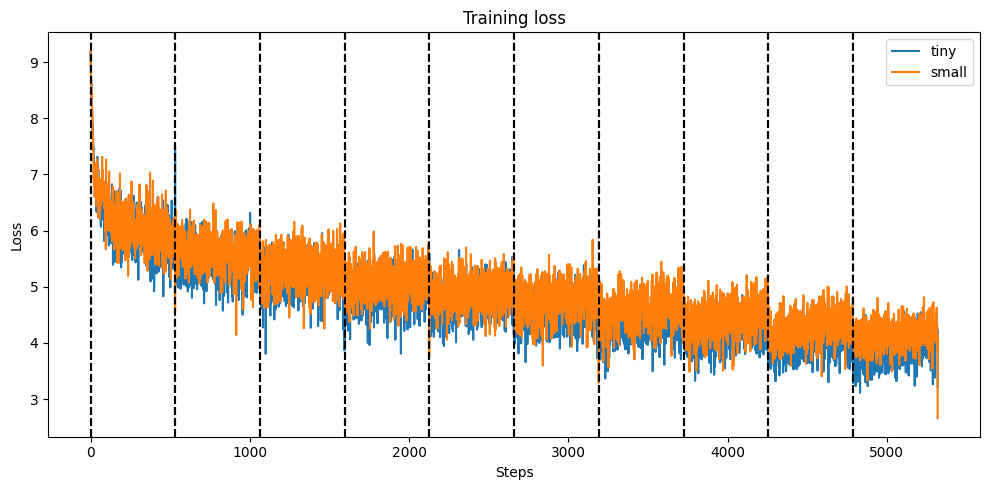

In [24]:
# Plot the losses for each model
fig, ax = plt.subplots(figsize=(10, 5))

for model_type, losses_per_epoch in losses_per_model.items():
    values_per_epoch = list(losses_per_epoch.values())
    values = np.array(values_per_epoch).flatten()

    ax.plot(values, label=model_type)

    # indcate when a new epoch starts
    for i, losses in enumerate(values_per_epoch):
        ax.axvline(x=len(losses) * i, color="k", linestyle="--")

ax.set_xlabel("Steps")
ax.set_ylabel("Loss")
ax.set_title("Training loss")
ax.legend()
plt.tight_layout()
plt.show()

In [25]:
# Run inference and check predictions

text = "Scotty did not go back to" # Let's take a sentence from the Brown corpus

# Tokenize the text
token_ids = tokenizer.encode(text)
tokens = tokenizer.indices_to_tokens(token_ids)
# print(token_ids)
# print(tokens)

# Convert to tensor
token_ids = torch.tensor(token_ids).unsqueeze(0) # make it a batch of size 1
# print(token_ids)

# Run inference
logits_per_model = {}
for model_type, model in trained_models.items():
    print(f"Running inference with {model_type} model")
    model.eval() # set the model to evaluation mode
    hidden_state, logits, loss, hidden_states, attention_weights = model.forward(token_ids)
    logits_per_model[model_type] = logits.detach().cpu()

Running inference with tiny model
Running inference with small model


In [26]:
# Convert logits to probabilities
probs_per_model = {k: F.softmax(v, dim=-1) for k, v in logits_per_model.items()}

# Get the predicted token
predicted_token_per_model = {k: torch.argmax(v, dim=-1) for k, v in probs_per_model.items()}

for model_type, predictions in predicted_token_per_model.items():
    print(f"Model: {model_type}")
    for batch_idx, prediction in enumerate(predictions):
        predicted_tokens = tokenizer.indices_to_tokens(prediction.tolist())
        print(f"Predicted tokens: {predicted_tokens}")


Model: tiny
Predicted tokens: ['He', 'said', 'not', 'care', '.', 'to', 'the', '?']
Model: small
Predicted tokens: ['``', 'was', 'not', 'not', '.', '.', 'the', '?']


Model: tiny
torch.Size([9306])


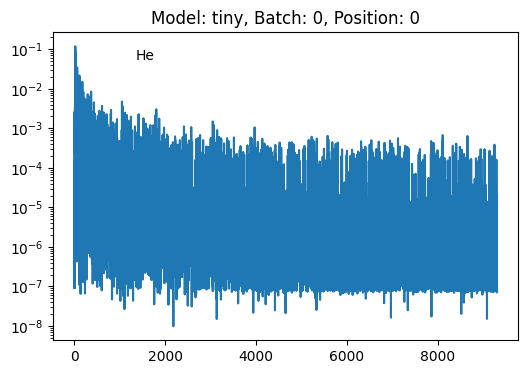

torch.Size([9306])


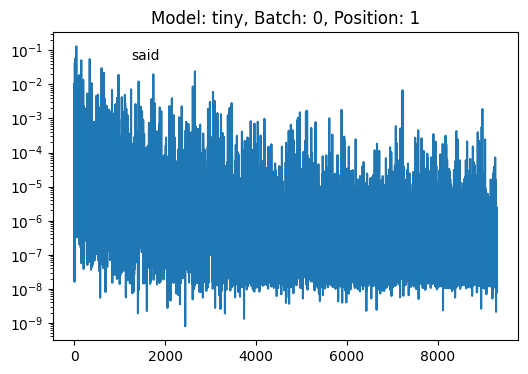

torch.Size([9306])


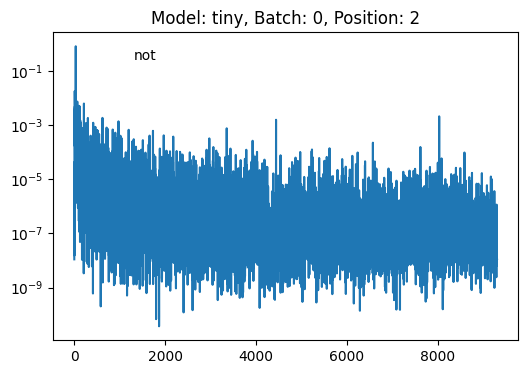

torch.Size([9306])


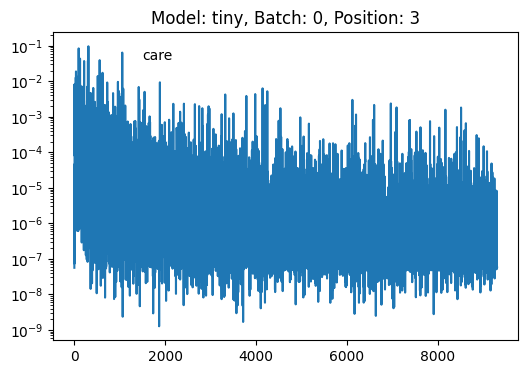

torch.Size([9306])


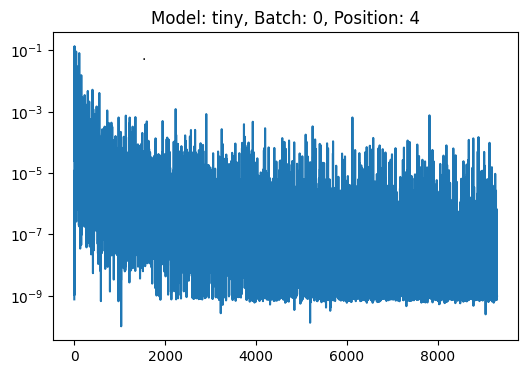

torch.Size([9306])


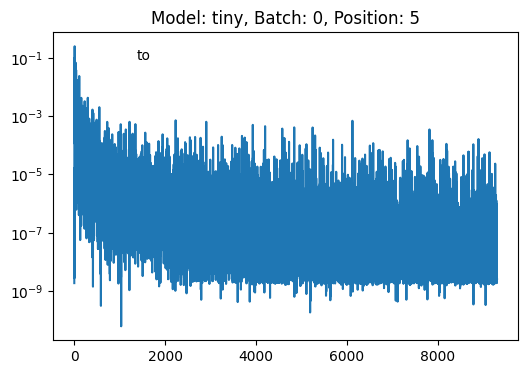

torch.Size([9306])


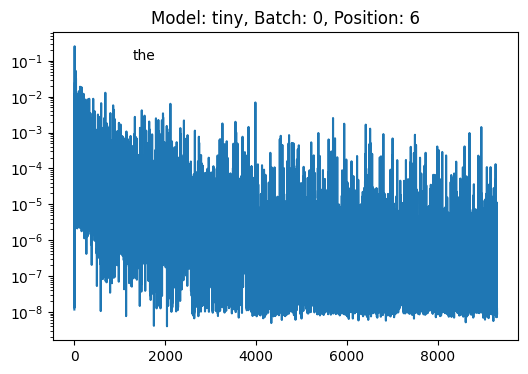

torch.Size([9306])


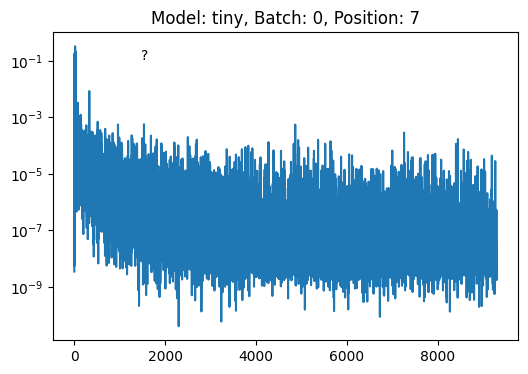

In [27]:
# Let's visualize the distribution over the vocabulary at every position in the sentence
for model_type, predictions in predicted_token_per_model.items():
    print(f"Model: {model_type}")
    for batch_idx, probs in enumerate(probs_per_model[model_type]):
        for pos_idx, prob in enumerate(probs):
            print(prob.shape)
            # make sure the probabilities sum to 1
            assert torch.allclose(prob.sum(), torch.tensor(1.0)), prob.sum()
            
            # visualize the probability distribution
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.plot(range(len(prob)), prob.tolist())
            ax.set_title(f"Model: {model_type}, Batch: {batch_idx}, Position: {pos_idx}")
            ax.set_yscale("log")

            # annotate witht the argmax 
            argmax = torch.argmax(prob).item()
            argmax_token = tokenizer.idx_to_token(argmax)
            ax.annotate(argmax_token, (argmax, prob[argmax]), textcoords="offset points", xytext=(50, -10), ha='center')

            plt.show()
            plt.close()
    break


---

## Huggingface transformers

Huggingface 🤗 transformers is a library that provides a wide range of pre-trained models for natural language processing (NLP). It includes models for language modeling, text classification, question answering, and more.It is the defacto standard for working with NLP models in PyTorch and is widely used in academia and industry.

In [42]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, GPTNeoXForCausalLM

Dataset is a library that provides a wide range of datasets in a unified format. It is useful for loading and preprocessing datasets.

In [32]:
dataset = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1", split="test")
dataset

Dataset({
    features: ['text'],
    num_rows: 4358
})

In [40]:
dataset[3]

{'text': ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n'}

In [41]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-14m")
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 128)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=128, out_features=384, bias=True)
          (dense): Linear(in_features=128, out_features=128, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=128, out_features=512, bias=True)
          (dense_4h_to_h): Linear(in_features=512, out_features=128, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_af

Each model comes with its own tokenizer. The tokenizer class handles all data preprocessing, including tokenization, detokenization, and encoding/decoding.

In [44]:
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-14m")

In [49]:
text = "Scotty did not go back to"
token_ids = tokenizer.encode(text, add_special_tokens=True)
tokens = tokenizer.convert_ids_to_tokens(token_ids) 
print(token_ids)
print(tokens)

[4316, 302, 555, 858, 417, 564, 896, 281]
['Sc', 'ot', 'ty', 'Ġdid', 'Ġnot', 'Ġgo', 'Ġback', 'Ġto']


In [53]:
generation = model.generate(torch.tensor(token_ids).unsqueeze(0), max_length=20)
print(generation)
tokenizer.decode(generation[0])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


tensor([[4316,  302,  555,  858,  417,  564,  896,  281,  253, 3369,   15,  187,
          187,    3,   42, 1353,  417, 2119,  604,  309]])


'Scotty did not go back to the door.\n\n"I\'m not sure if I'